In [1]:
import os
import shutil
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import layers

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report


In [2]:
# Step 2: Remove nested folders inside class directories (if any)

base_path = r"D:\Animal_dataset"

for class_name in os.listdir(base_path):
    class_path = os.path.join(base_path, class_name)
    
    if not os.path.isdir(class_path):
        continue  # Skip if it's not a folder

    # Look inside class folder for nested folders
    for nested in os.listdir(class_path):
        nested_path = os.path.join(class_path, nested)
        if os.path.isdir(nested_path):
            # Move all files up from nested folder to class folder
            for file in os.listdir(nested_path):
                src = os.path.join(nested_path, file)
                dst = os.path.join(class_path, file)
                if os.path.isfile(src):
                    shutil.move(src, dst)
            os.rmdir(nested_path)  # Optional: delete empty folder
            print(f"✅ Moved files from {nested_path} to {class_path}")


In [3]:
# Step 3: Load dataset from directory
dataset = tf.keras.utils.image_dataset_from_directory(
    base_path,
    labels="inferred",
    label_mode="int",  
    image_size=(256, 256),
    batch_size=32,
    shuffle=True
)

# Save class names for later use
class_names = dataset.class_names
print("✅ Classes found:", class_names)


Found 1038 files belonging to 3 classes.
✅ Classes found: ['Foot and Mouth disease', 'Lumpy Skin', 'Normal Skin']


In [4]:
# Step 4: Convert the loaded dataset into NumPy arrays
X = []
y = []

for images, labels in dataset:
    X.append(images.numpy())
    y.append(labels.numpy())

X = np.concatenate(X)
y = np.concatenate(y)

print("✅ Data shape:", X.shape, y.shape)


✅ Data shape: (1038, 256, 256, 3) (1038,)


In [5]:
# Step 5: Split the data into train, validation, and test sets

X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)


X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42
)

print("✅ Split complete")
print(f"Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")


✅ Split complete
Train: (726, 256, 256, 3), Val: (156, 256, 256, 3), Test: (156, 256, 256, 3)


In [6]:
# Step 6: Convert to tf.data.Dataset and normalize images

train = tf.data.Dataset.from_tensor_slices((X_train, y_train)).map(
    lambda x, y: (x / 255.0, y)).shuffle(100).batch(32)

val = tf.data.Dataset.from_tensor_slices((X_val, y_val)).map(
    lambda x, y: (x / 255.0, y)).batch(32)

test = tf.data.Dataset.from_tensor_slices((X_test, y_test)).map(
    lambda x, y: (x / 255.0, y)).batch(32)

print("✅ TensorFlow datasets ready")
print(f"Train batches: {len(train)}, Val batches: {len(val)}, Test batches: {len(test)}")


✅ TensorFlow datasets ready
Train batches: 23, Val batches: 5, Test batches: 5


In [7]:
# Step 7: Data Augmentation
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

print("✅ Data augmentation layer ready")


✅ Data augmentation layer ready


In [8]:
# Step 8: Define CNN model
model = Sequential([
    Input(shape=(256, 256, 3)),

    data_augmentation,  # Apply augmentation only on training

    Conv2D(16, (3, 3), activation='relu'),
    MaxPooling2D(),
    Dropout(0.25),

    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(),
    Dropout(0.25),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(),
    Dropout(0.25),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),

    Dense(len(class_names), activation='softmax')  # output layer
])

# Compile the model
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 254, 254, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 127, 127, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 62, 62, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 57600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     7,372,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,396,899 (28.22 MB)

 Trainable params: 7,396,899 (28.22 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
# Step 9: Train the model with early stopping
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

history = model.fit(
    train,
    validation_data=val,
    epochs=15,
    callbacks=[early_stop]
)


Epoch 1/15
23/23 ━━━━━━━━━━━━━━━━━━━━ 13s 484ms/step - accuracy: 0.5035 - loss: 5.0620 - val_accuracy: 0.5769 - val_loss: 1.0354
Epoch 2/15
23/23 ━━━━━━━━━━━━━━━━━━━━ 11s 486ms/step - accuracy: 0.6051 - loss: 0.8942 - val_accuracy: 0.5769 - val_loss: 0.9741
Epoch 3/15
23/23 ━━━━━━━━━━━━━━━━━━━━ 11s 473ms/step - accuracy: 0.6254 - loss: 0.8459 - val_accuracy: 0.6282 - val_loss: 0.9173
Epoch 4/15
23/23 ━━━━━━━━━━━━━━━━━━━━ 11s 481ms/step - accuracy: 0.6331 - loss: 0.8178 - val_accuracy: 0.6154 - val_loss: 0.8927
Epoch 5/15
23/23 ━━━━━━━━━━━━━━━━━━━━ 11s 485ms/step - accuracy: 0.6498 - loss: 0.7982 - val_accuracy: 0.6603 - val_loss: 0.8083
Epoch 6/15
23/23 ━━━━━━━━━━━━━━━━━━━━ 11s 489ms/step - accuracy: 0.6831 - loss: 0.7472 - val_accuracy: 0.6667 - val_loss: 0.7696
Epoch 7/15
23/23 ━━━━━━━━━━━━━━━━━━━━ 11s 485ms/step - accuracy: 0.6645 - loss: 0.7125 - val_accuracy: 0.6474 - val_loss: 0.7521
Epoch 8/15
23/23 ━━━━━━━━━━━━━━━━━━━━ 12s 507ms/step - accuracy: 0.6962 - loss: 0.6912 - val_accu

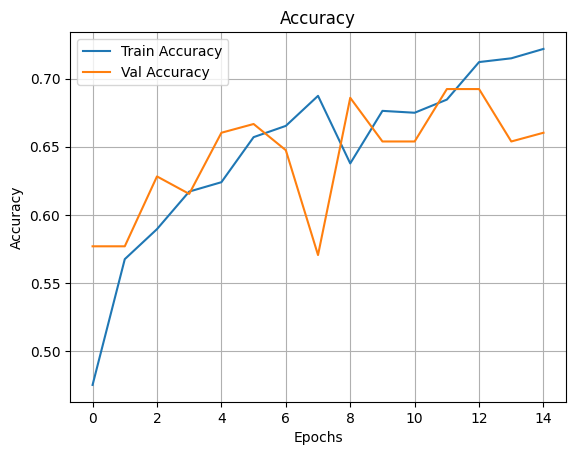

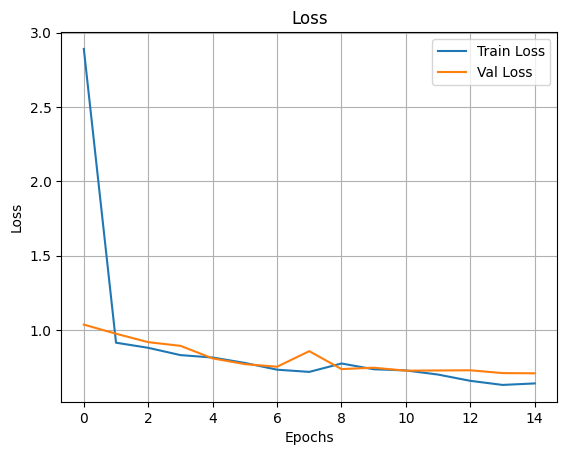

In [10]:
# Step 10: Plot training and validation accuracy and loss

# Accuracy Plot
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Loss Plot
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


In [11]:
# Step 11: Evaluate on test set
from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy

pre = Precision()
re = Recall()
acc = CategoricalAccuracy()

for batch in test:
    X_batch, y_batch = batch
    y_pred = model.predict(X_batch)
    y_pred_labels = tf.argmax(y_pred, axis=1)
    y_true_onehot = tf.one_hot(y_batch, depth=len(class_names))

    pre.update_state(y_true_onehot, y_pred)
    re.update_state(y_true_onehot, y_pred)
    acc.update_state(y_true_onehot, y_pred)

print(f"📊 Precision: {pre.result().numpy():.2f}")
print(f"📊 Recall: {re.result().numpy():.2f}")
print(f"📊 Accuracy: {acc.result().numpy():.2f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step
📊 Precision: 0.82
📊 Recall: 0.51
📊 Accuracy: 0.72


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


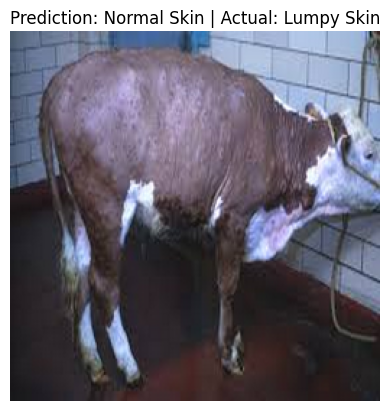

In [13]:
# Step 12: Pick a random image from test set and make a prediction
import random

# Get one batch of test data
test_batch = test.as_numpy_iterator().next()
images, labels = test_batch

# Choose a random image from the batch
idx = random.randint(0, len(images) - 1)
img = images[idx]
label = labels[idx]

# Predict the class
pred = model.predict(np.expand_dims(img, axis=0))
predicted_class = class_names[np.argmax(pred)]

# Show image with predicted and actual label
plt.imshow(img)
plt.title(f"Prediction: {predicted_class} | Actual: {class_names[label]}")
plt.axis('off')
plt.show()


In [14]:
# Step 13: Save the trained model
model_path = "D:/animal_disease_cnn_model.h5"
model.save(model_path)
print("✅ Model saved at:", model_path)


✅ Model saved at: D:/animal_disease_cnn_model.h5


In [16]:
from sklearn.metrics import f1_score

# Get predictions and true labels
y_true = []
y_pred = []

for X_batch, y_batch in test:
    preds = model.predict(X_batch)
    pred_labels = tf.argmax(preds, axis=1).numpy()

    y_true.extend(y_batch.numpy())
    y_pred.extend(pred_labels)

# Calculate and print the weighted F1 score
f1 = f1_score(y_true, y_pred, average='weighted')
print(f"📊 F1 Score (weighted): {f1:.2f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
📊 F1 Score (weighted): 0.81
